# Imports

In [1]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }

from __future__ import absolute_import, division, print_function

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass



#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
           tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

&lt;module &#39;tensorflow._api.v2.config&#39; from &#39;/Users/Sahil_Maheshwari-MUM/opt/anaconda3/lib/python3.7/site-packages/tensorflow/_api/v2/config/__init__.py&#39;&gt;

# Example: Coin Toss 

In [2]:
# Define the genrating process to simulate coin flips
p = 0.5
rv_coin_flip_prior = tfp.distributions.Bernoulli(probs=p, dtype=tf.int32)

# sample 'max_num_trials' coin flips
max_num_trials = 2000
coin_flip_data = rv_coin_flip_prior.sample(max_num_trials)
# prepend a 0 onto tally of heads and tails, for zeroth flip
coin_flip_data = tf.pad(coin_flip_data, tf.constant([[1, 0]]))

# compute cumulative headcounts from 0 to 'max_num_trials' flips, and then grab them at each of num_trials intervals
num_trials = tf.constant([0, 1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, max_num_trials])
cumulative_headcounts = tf.gather(tf.cumsum(coin_flip_data), num_trials)

# Define posterior distribution at different intervals of coin tosses
# i.e. there will be multiple posterior distributions, one for each num_trials
rv_observed_heads = tfp.distributions.Beta(
    concentration1=tf.cast(1 + cumulative_headcounts, tf.float32),
    concentration0=tf.cast(1 + num_trials - cumulative_headcounts, tf.float32)
)
# Here we have directly used a known solution of posterior instead of using bayes formula
# For the known solution we have assumed:
#   a uniform or beta(1,1) prior: https://www.quantstart.com/articles/Bayesian-Inference-of-a-Binomial-Proportion-The-Analytical-Approach/
#   a binomial likelihood

# Re-shape to get the output in desired format
probs_of_heads = tf.linspace(start=0., stop=1., num=100, name="linspace")
observed_probs_heads = tf.transpose(rv_observed_heads.prob(probs_of_heads[:, tf.newaxis]))
# Final shape is (no. of num_trials intervals, no. of points between 0 and 1 i.e. 100 here)
# So, each row is a PDF

In [11]:
observed_probs_heads.shape

TensorShape([12, 100])

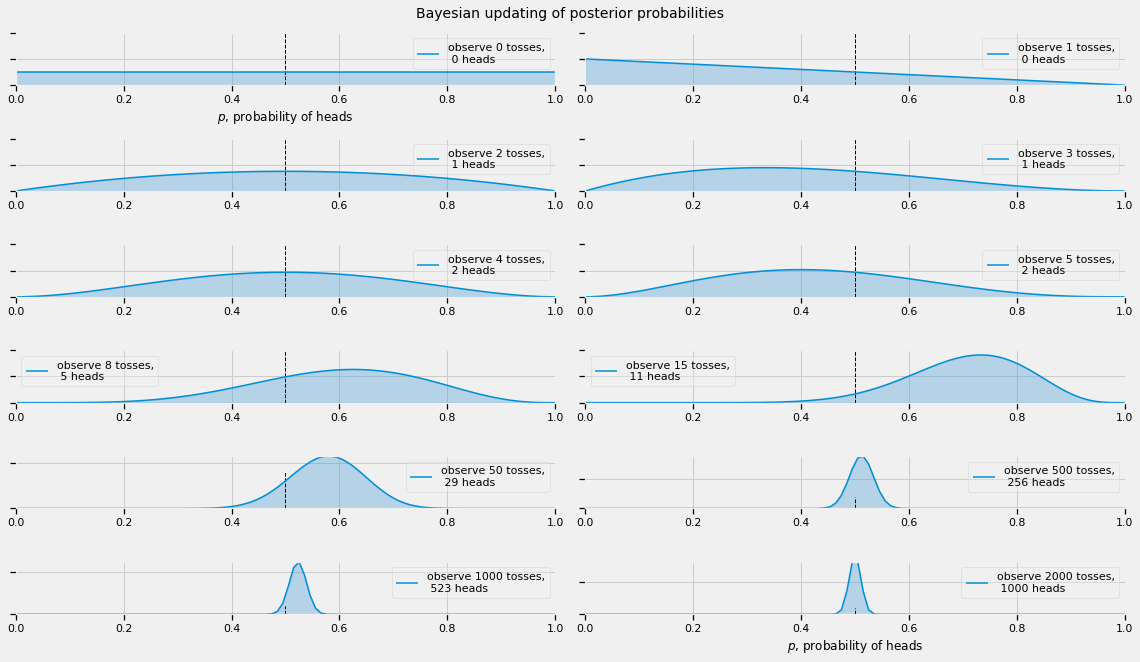

In [17]:
plt.figure(figsize(16, 9))
for i in range(len(num_trials)):
    sx = plt.subplot(len(num_trials)/2, 2, i+1)
    plt.xlabel("$p$, probability of heads") if i in [0, len(num_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.plot(probs_of_heads, observed_probs_heads[i], label="observe %d tosses,\n %d heads" % (num_trials[i], cumulative_headcounts[i]))
    plt.fill_between(probs_of_heads, 0, observed_probs_heads[i], color=TFColor[3], alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)

plt.suptitle("Bayesian updating of posterior probabilities", y=1.02, fontsize=14)
plt.tight_layout()

# Example: Bug, or just sweet, unintended feature? 

Make plots using any library which is less verbose than 'matplotlib'

event A -> no bug in code  
event X -> all test passes  

Generating model or Likelihood function:  
So, P(X|A) = 1, by definition of events  
Let, P(X|~A) = 0.5 (this is our super simplified generating model)  

Prior:  
p = tf.linspace(start=0., stop=1., num=50)


# Distributions

## Poisson (Discrete)

$$P(Z = k) =\frac{ \lambda^k e^{-\lambda} }{k!}, \; \; k=0,1,2, \dots $$

$k$ can be a non-negative integer

$\lambda$  can be any positive number. By increasing  𝜆 , we add more probability to larger values, and conversely by decreasing  𝜆  we add more probability to smaller values

$$E\large[ \;Z\; | \; \lambda \;\large] = \lambda $$


## Exponential (Continuous)

$$f_Z(z | \lambda) = \lambda e^{-\lambda z }, \;\; z\ge 0$$

$$E[\; Z \;|\; \lambda \;] = \frac{1}{\lambda}$$



# Example: Inferring behaviour from text-message data

observed data: daily text mesaage count

Generating model:  
$$C_i \sim \text{Poisson}(\lambda)$$  

$$
\lambda = 
\begin{cases} \lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$  

$$
\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}
$$

$$
\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) } & \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}
$$